In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models
from IPython import display

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
Found 8000 files belonging to 8 classes.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
Target Keywords: ['up', 'down', 'left', 'right']
Unknown Keywords: ['go', 'no', 'stop', 'yes']
New Class to Index Mapping: {'up': 0, 'down': 1, 'left': 2, 'right': 3, 'unknown': 4, 'silence': 5}

Samples shape: (8, 16000)
Labels shape: (8,)
Unique labels in batch: [0 2 3 4 5]


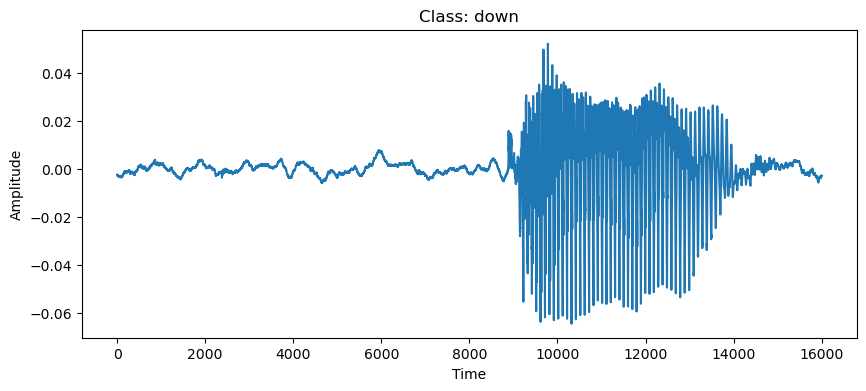

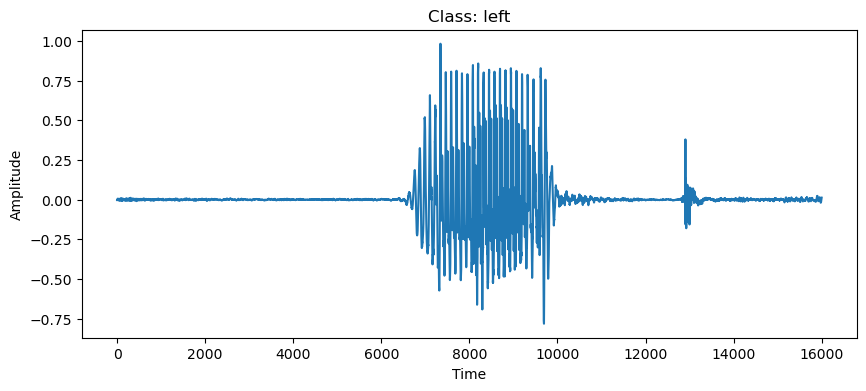

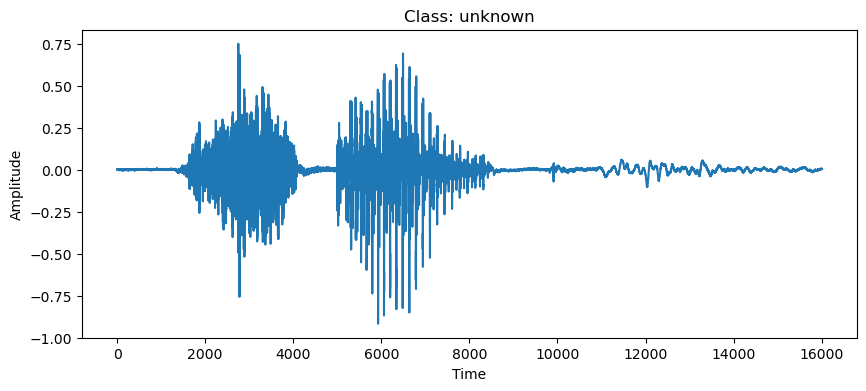

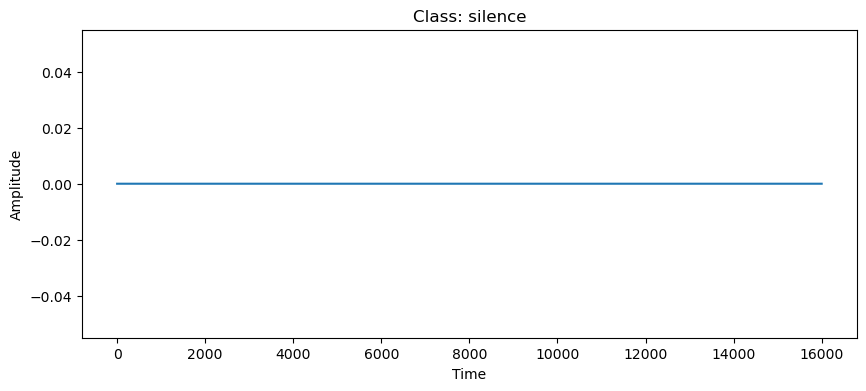

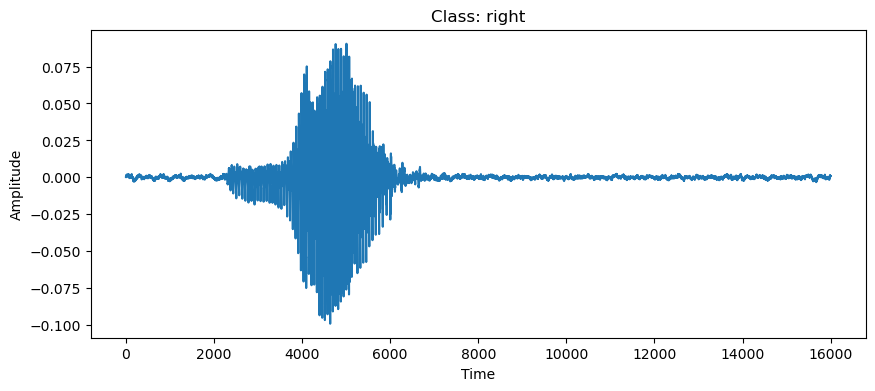

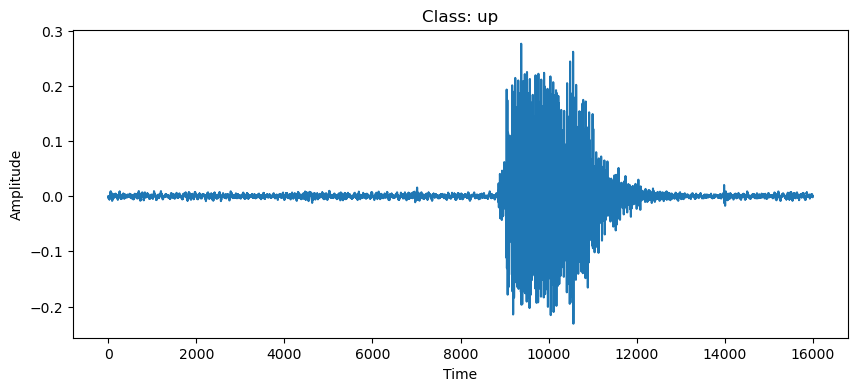

Total number of samples: 10000
Number of training batches: 1000
Number of validation batches: 125
Number of test batches: 125
Number of training samples: 8000
Number of validation samples: 1000
Number of test samples: 1000
Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


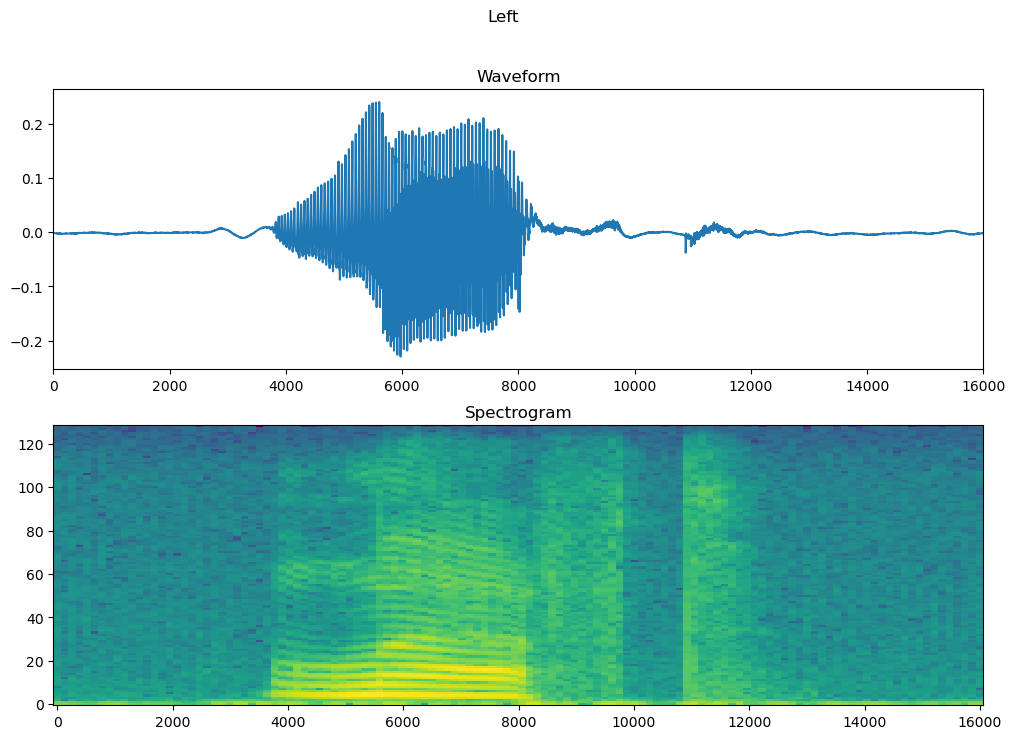

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


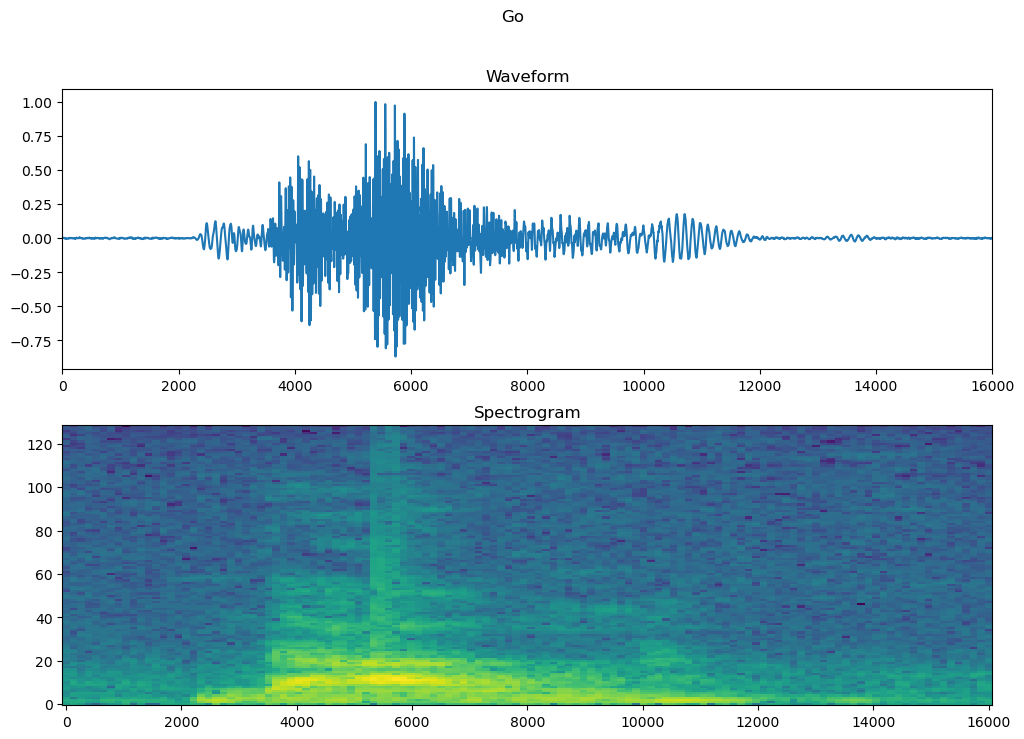

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


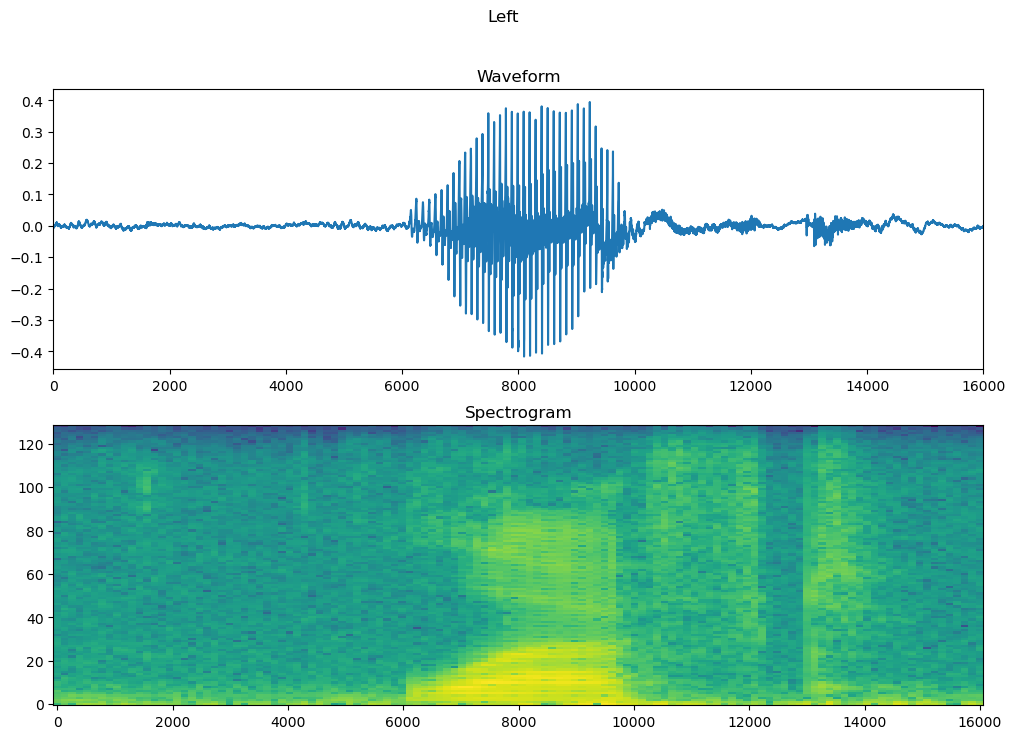

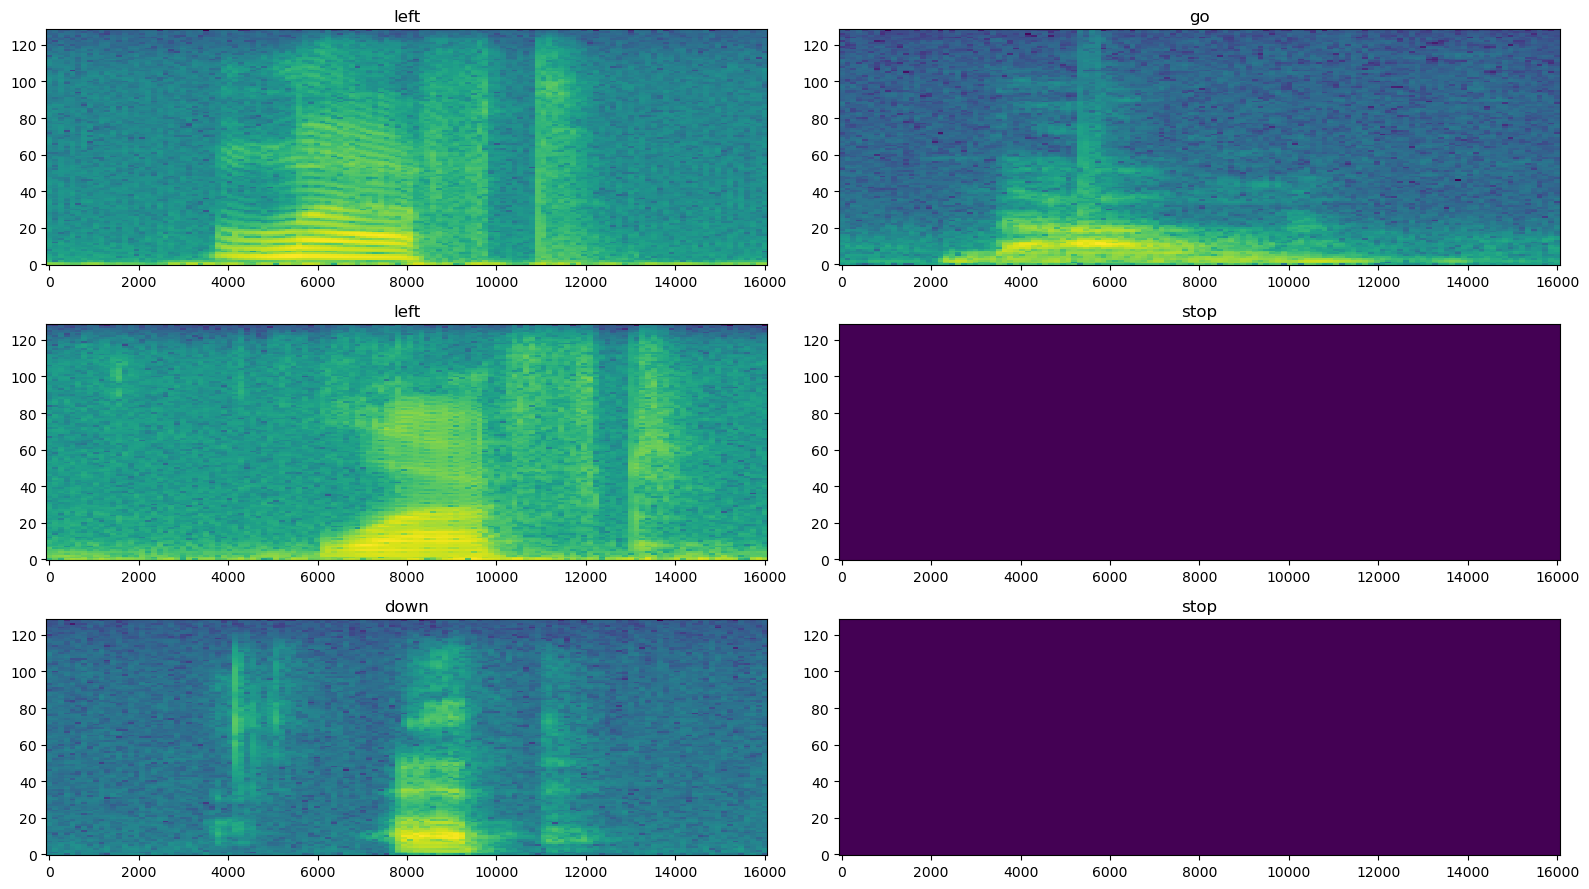

In [2]:
from audio_model_training import train_spectrogram_ds, test_spectrogram_ds, val_spectrogram_ds

In [3]:
# Cache and prefetch datasets for faser reading when training
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [4]:
# Get input shape and number of classes
for spectrograms, labels in train_spectrogram_ds.take(1):
    input_shape = spectrograms.shape
    num_classes = 6
    print('Input shape:', input_shape)
    print('Number of classes:', num_classes)

Input shape: (8, 124, 129, 1)
Number of classes: 6


# Define models

[model inspiration paper](https://www.isca-archive.org/interspeech_2015/sainath15b_interspeech.html)

[model inspiration code from TF](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/speech_commands/models.py#L673)

^^^ two OG papers that are definitelly good

[general keywrod spotting on microcontroller paper](https://arxiv.org/abs/1711.07128)


[binary quantization paper, might not be possible with tf and espressif](https://www.isca-archive.org/interspeech_2022/wang22g_interspeech.html)

These two papers go into other possible model architecutes:

[model with temporal convolutions](https://www.isca-archive.org/interspeech_2020/li20s_interspeech.html)

[depthwise conv](https://www.isca-archive.org/interspeech_2020/xu20d_interspeech.html) this might be very good

maybe for NAS:

[micronets maybe for NAS](https://arxiv.org/abs/2010.11267)

In [5]:
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dense, Activation, Input, Reshape, Multiply, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, ReLU, Dropout

In [6]:
# Function to plot training history (accuracy and loss)
def plot_training_history(history, model_number):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Model {model_number} - Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Model {model_number} - Training and Validation Loss')
    plt.show()


In [7]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

### Resnet types model

In [8]:


def squeeze_excite_block(input_tensor, ratio=4):
    filters = input_tensor.shape[-1]
    se_shape = (1, 1, filters)

    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)

    # Excitation: Bottleneck with two Dense layers
    se = Dense(max(filters // ratio, 1), activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)

    # Scale: Multiply the input tensor by the recalibrated weights
    x = Multiply()([input_tensor, se])
    return x

# Depthwise Separable Convolution Block
def depthwise_separable_conv_block(x, filters, kernel_size=(4, 4), strides=(1, 1), padding='same'):
    x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding=padding, use_bias=True)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=(1, 1), padding='same', use_bias=True)(x)
    x = Activation('relu')(x)
    return x

In [9]:
# Optimized DS-ResNet10 Model with Squeeze-and-Excitation Block
def ds_resnet10_se(input_shape=(124, 129, 1), num_classes=6):
    inputs = Input(shape=input_shape)

    # Initial Conv Layer
    x = Conv2D(64, (4, 4), padding='same', use_bias=True)(inputs)
    x = Activation('relu')(x)

    # Squeeze-and-Excitation block
    # x = squeeze_excite_block(x, ratio=2)

    # Depthwise Separable Convolutional Layers
    for _ in range(1):
        x = depthwise_separable_conv_block(x, filters=16)
        # Squeeze-and-Excitation block after each DS Conv Block
        # x = squeeze_excite_block(x, ratio=2)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Output Layer
    outputs = Dense(num_classes)(x)

    # Model Definition
    model = Model(inputs, outputs)
    return model

### Basic Model 

This model is large but achieves decent accuracy

In [10]:
# A basic model with Conv2D layers, MaxPooling, and Dropout for regularization
def create_model_1(input_shape, num_classes):
    model = tf.keras.models.Sequential([
    layers.Input(shape=(129, 124, 1)),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes),
])
    return model

## Model 2 smaller version of model 1

In [11]:
# Reduced complexity for faster training and smaller size
def create_model_2(input_shape, num_classes):
    model = tf.keras.models.Sequential([
    layers.Input(shape=(129, 124, 1)),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    #layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes),
    ])
    return model

## Model 3 Tiny Conv model from paper

In [12]:
def create_tiny_conv_model_small(input_shape, num_classes=6, is_training=True):
    """
    Builds a tiny convolutional model optimized for microcontrollers.

    Args:
        input_shape: Tuple, the shape of the input data (time_steps, frequency_bins, channels).
        num_classes: Integer, number of output classes.
        is_training: Boolean, whether the model is being trained or deployed.

    Returns:
        model: Keras Model instance.
    """
    inputs = Input(shape=(124, 129, 1), name='input')

    # Convolutional Layer
    x = Conv2D(filters=8,
               kernel_size=(10, 8),
               strides=(2, 2),
               padding='same',
               use_bias=True,
               kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
               bias_initializer='zeros',
               name='conv')(inputs)
    
    # ReLU Activation
    x = ReLU(name='relu1')(x)
    
    # Optional Dropout Layer
    if is_training:
        x = Dropout(rate=0.2, name='dropout1')(x)
    
    # Flatten the output
    x = Flatten(name='flatten')(x)
    
    # Output Layer
    outputs = Dense(units=num_classes,
                    activation='softmax',  # Use 'softmax' if you prefer probabilities
                    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
                    bias_initializer='zeros',
                    name='fc2')(x)
    
    # Define the model
    model = Model(inputs=inputs, outputs=outputs, name='tiny_conv_model')
    
    return model


In [13]:
def create_tiny_embed_conv_model_small(input_shape, num_classes=6, is_training=True):
    """
    Builds a tiny convolutional model optimized for microcontrollers.

    Args:
        input_shape: Tuple, the shape of the input data (time_steps, frequency_bins, channels).
        num_classes: Integer, number of output classes.
        is_training: Boolean, whether the model is being trained or deployed.

    Returns:
        model: Keras Model instance.
    """
    inputs = Input(shape=(124, 129, 1), name='input')

    # Convolutional Layer
    x = Conv2D(filters=8,
               kernel_size=(10, 8),
               strides=(2, 2),
               padding='same',
               use_bias=True,
               kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
               bias_initializer='zeros',
               name='conv1')(inputs)
    
    # ReLU Activation
    x = ReLU(name='relu1')(x)
    
    # Optional Dropout Layer
    if is_training:
        x = Dropout(rate=0.2, name='dropout1')(x)

    # Convolutional Layer
    x = Conv2D(filters=8,
               kernel_size=(10, 8),
               strides=(8, 8),
               padding='same',
               use_bias=True,
               kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
               bias_initializer='zeros',
               name='conv2')(x)
    
    # ReLU Activation
    x = ReLU(name='relu2')(x)
    
    # Optional Dropout Layer
    if is_training:
        x = Dropout(rate=0.2, name='dropout2')(x)
    
    # Flatten the output
    x = Flatten(name='flatten')(x)
    
    # Output Layer
    outputs = Dense(units=num_classes,
                    activation='softmax',  # Use 'softmax' if you prefer probabilities
                    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
                    bias_initializer='zeros',
                    name='fc2')(x)
    
    # Define the model
    model = Model(inputs=inputs, outputs=outputs, name='tiny_embed_conv_model')
    
    return model


Best hyperparameters: {'kernel_size_1_height': 9, 'kernel_size_1_width': 9, 'stride_1_height': 2, 'stride_1_width': 1, 'conv1_filters': 16, 'dropout_1': True, 'kernel_size_2_height': 7, 'kernel_size_2_width': 7, 'stride_2_height': 4, 'stride_2_width': 6, 'conv2_filters': 12, 'dropout_2': True, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}

In [14]:
def create_tiny_embed_conv_model_small_best(input_shape, num_classes=6, is_training=True):
    """
    Builds a tiny convolutional model optimized for microcontrollers.

    Args:
        input_shape: Tuple, the shape of the input data (time_steps, frequency_bins, channels).
        num_classes: Integer, number of output classes.
        is_training: Boolean, whether the model is being trained or deployed.

    Returns:
        model: Keras Model instance.
    """
    inputs = Input(shape=(124, 129, 1), name='input')

    # Convolutional Layer
    x = Conv2D(filters=16,
               kernel_size=(9, 9),
               strides=(2, 1),
               padding='same',
               use_bias=True,
               kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
               bias_initializer='zeros',
               name='conv1')(inputs)
    
    # ReLU Activation
    x = ReLU(name='relu1')(x)
    
    # Optional Dropout Layer
    if is_training:
        x = Dropout(rate=0.2, name='dropout1')(x)

    # Convolutional Layer
    x = Conv2D(filters=12,
               kernel_size=(7, 7),
               strides=(4, 6),
               padding='same',
               use_bias=True,
               kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
               bias_initializer='zeros',
               name='conv2')(x)
    
    # ReLU Activation
    x = ReLU(name='relu2')(x)
    
    # Optional Dropout Layer
    if is_training:
        x = Dropout(rate=0.2, name='dropout2')(x)
    
    # Flatten the output
    x = Flatten(name='flatten')(x)
    
    # Output Layer
    outputs = Dense(units=num_classes,
                    activation='softmax',  # Use 'softmax' if you prefer probabilities
                    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
                    bias_initializer='zeros',
                    name='fc2')(x)
    
    # Define the model
    model = Model(inputs=inputs, outputs=outputs, name='tiny_embed_conv_model_best')
    
    return model


## Train Models


Training Model 1


Model: "tiny_conv_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 124, 129, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv (Conv2D)                   │ (None, 62, 65, 8)      │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 62, 65, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 62, 65, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 6)              │       193,446 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,094 (758.18 KB)

 Trainable params: 194,094 (758.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


c:\Users\adamk\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


   1000/Unknown 3s 3ms/step - accuracy: 0.5768 - loss: 1.1748

c:\Users\adamk\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5769 - loss: 1.1747 - val_accuracy: 0.6620 - val_loss: 0.9164
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7092 - loss: 0.7930 - val_accuracy: 0.7070 - val_loss: 0.8246
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7735 - loss: 0.6242 - val_accuracy: 0.7280 - val_loss: 0.8353
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7977 - loss: 0.5677 - val_accuracy: 0.7690 - val_loss: 0.7814
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8196 - loss: 0.5044 - val_accuracy: 0.7490 - val_loss: 0.7390
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8373 - loss: 0.4517 - val_accuracy: 0.7790 - val_loss: 0.7080
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8665 - loss: 0.3880 - val_accuracy: 0.7840 - val_loss: 0.6957
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8837 - loss: 0.3269 - val_accurac

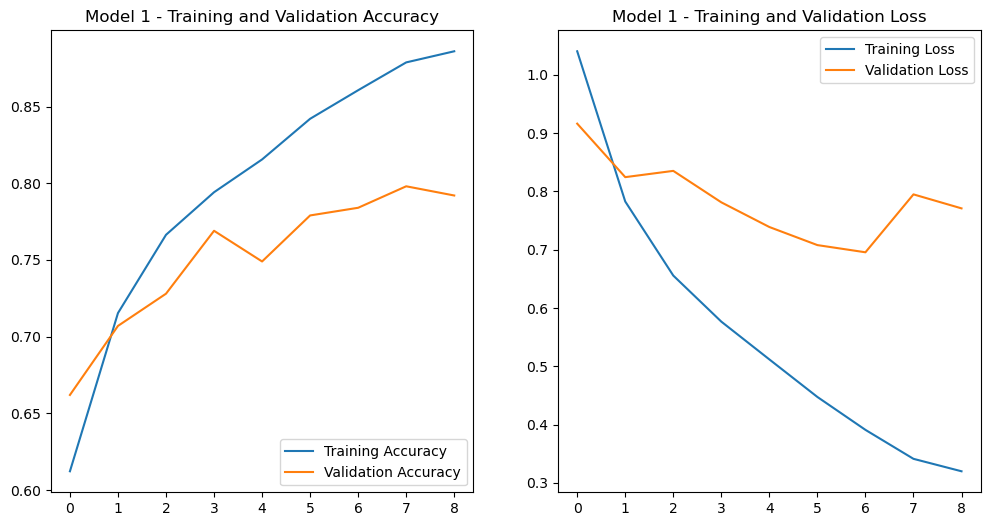


Training Model 2


Model: "tiny_embed_conv_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 124, 129, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 62, 65, 8)      │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 62, 65, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 62, 65, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 8, 9, 8)        │         5,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (ReLU)                    │ (None, 8, 9, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 8, 9, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 6)              │         3,462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,238 (36.09 KB)

 Trainable params: 9,238 (36.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5421 - loss: 1.2615 - val_accuracy: 0.6410 - val_loss: 1.0473
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6518 - loss: 0.9282 - val_accuracy: 0.6790 - val_loss: 0.8390
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7032 - loss: 0.7856 - val_accuracy: 0.7380 - val_loss: 0.7197
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7451 - loss: 0.6936 - val_accuracy: 0.7820 - val_loss: 0.6596
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7711 - loss: 0.6368 - val_accuracy: 0.7940 - val_loss: 0.6235
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7868 - loss: 0.5897 - val_accuracy: 0.8210 - val_loss: 0.5762
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8058 - loss: 0.5633 - val_accuracy: 0.8320 - val_loss: 0.5218
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8119 - loss: 0.5305 - 

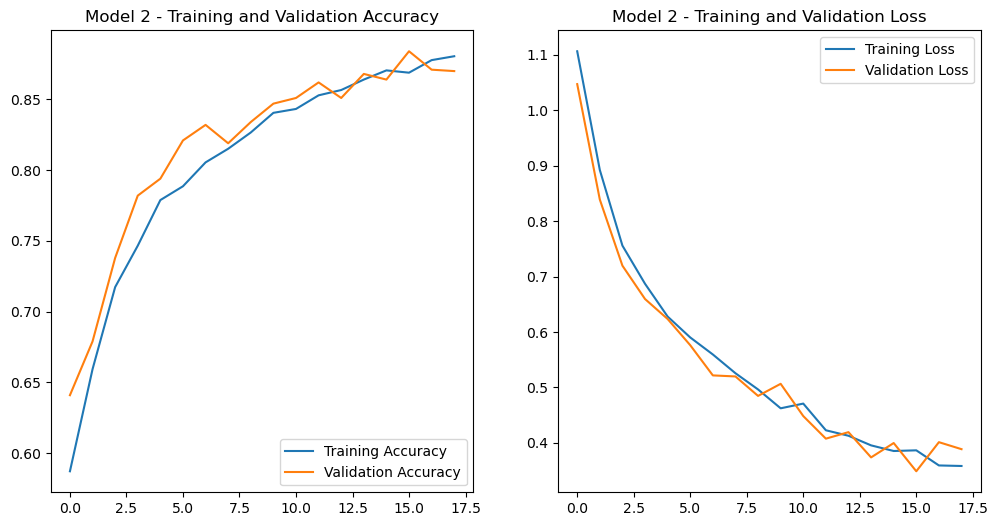


Training Model 3


Model: "tiny_embed_conv_model_best"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 124, 129, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 62, 129, 16)    │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 62, 129, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 62, 129, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 16, 22, 12)     │         9,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (ReLU)                    │ (None, 16, 22, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 16, 22, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4224)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 6)              │        25,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,082 (140.95 KB)

 Trainable params: 36,082 (140.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5611 - loss: 1.2053 - val_accuracy: 0.7050 - val_loss: 0.7961
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7182 - loss: 0.7852 - val_accuracy: 0.7830 - val_loss: 0.6201
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7947 - loss: 0.5734 - val_accuracy: 0.8150 - val_loss: 0.5192
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8322 - loss: 0.4952 - val_accuracy: 0.8470 - val_loss: 0.4467
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8625 - loss: 0.4052 - val_accuracy: 0.8900 - val_loss: 0.4117
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8913 - loss: 0.3398 - val_accuracy: 0.8720 - val_loss: 0.4528
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8892 - loss: 0.3250 - val_accuracy: 0.9020 - val_loss: 0.3712
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9093 - loss: 0.2842 - 

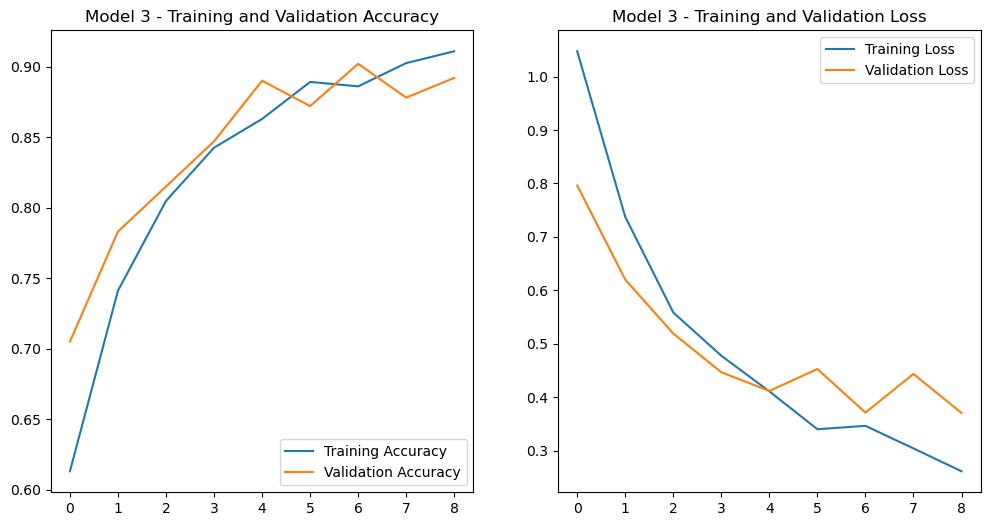

In [15]:
models = []
histories = []

for i, create_model in enumerate([create_tiny_conv_model_small, create_tiny_embed_conv_model_small, create_tiny_embed_conv_model_small_best], start=1):
    print(f'\nTraining Model {i}')
    model = create_model(input_shape, num_classes)
    model.summary()
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    history = model.fit(
        train_spectrogram_ds,
        validation_data=val_spectrogram_ds,
        epochs=20,  # You can adjust the number of epochs
        callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2, min_delta=0.01),
        verbose = 1
    )
    models.append(model)
    histories.append(history)
    plot_training_history(history, i)


# Compile and Train models

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8009 - loss: 0.7428
Total non-trainable parameters: 0.0
Total trainable parameters: 194094
Model 1 Test Accuracy: 0.7980
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.8777 - loss: 0.3563
Total non-trainable parameters: 0.0
Total trainable parameters: 9238
Model 2 Test Accuracy: 0.8680
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8790 - loss: 0.4000
Total non-trainable parameters: 0.0
Total trainable parameters: 36082
Model 3 Test Accuracy: 0.8710


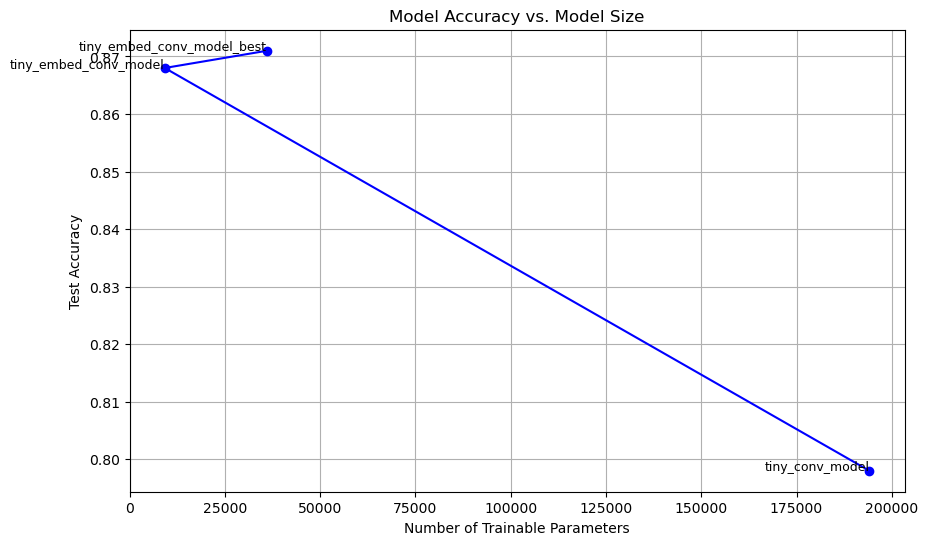

In [16]:
# List to store the results
accuracies = []
model_sizes = []
model_names = []

# Evaluate each model and store the results
for i, model in enumerate(models, start=1):
    test_loss, test_acc = model.evaluate(test_spectrogram_ds)
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
    
    # Print the details
    print(f"Total non-trainable parameters: {non_trainable_params}")
    print(f"Total trainable parameters: {trainable_params}")
    print(f'Model {i} Test Accuracy: {test_acc:.4f}')
    
    # Store the accuracy and model size
    accuracies.append(test_acc)
    model_sizes.append(trainable_params)
    model_names.append(model.name)

# Plotting accuracy vs. model size
plt.figure(figsize=(10, 6))
plt.plot(model_sizes, accuracies, marker='o', linestyle='-', color='b')

for i, model_name in enumerate(model_names):
    plt.text(model_sizes[i], accuracies[i], model_name, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Number of Trainable Parameters')
plt.ylabel('Test Accuracy')
plt.title('Model Accuracy vs. Model Size')

# Display the plot
plt.grid(True)
plt.show()


### Hyperparameter tuning

In [17]:
gridsearch = False

In [18]:
import keras_tuner as kt

def build_model(hp):
    input_shape = (124, 129, 1)
    num_classes = 6
    
    inputs = Input(shape=input_shape, name='input')

    # First convolutional layer
    kernel_size_1 = (hp.Int('kernel_size_1_height', min_value=3, max_value=10, step=2), 
                     hp.Int('kernel_size_1_width', min_value=3, max_value=10, step=2))
    stride_1 = (hp.Int('stride_1_height', min_value=1, max_value=2, step=1), 
                hp.Int('stride_1_width', min_value=1, max_value=2, step=1))
    
    x = Conv2D(filters=hp.Int('conv1_filters', min_value=4, max_value=16, step=4),
               kernel_size=kernel_size_1,
               strides=stride_1,
               padding='same',
               use_bias=True,
               name='conv1')(inputs)
    
    x = ReLU(name='relu1')(x)
    
    if hp.Boolean('dropout_1'):
        x = Dropout(rate=0.2, name='dropout1')(x)

    # Second convolutional layer
    kernel_size_2 = (hp.Int('kernel_size_2_height', min_value=3, max_value=10, step=2), 
                     hp.Int('kernel_size_2_width', min_value=3, max_value=10, step=2))
    stride_2 = (hp.Int('stride_2_height', min_value=4, max_value=8, step=2), 
                hp.Int('stride_2_width', min_value=4, max_value=8, step=2))
    
    x = Conv2D(filters=hp.Int('conv2_filters', min_value=4, max_value=16, step=4),
               kernel_size=kernel_size_2,
               strides=stride_2,
               padding='same',
               use_bias=True,
               name='conv2')(x)
    
    x = ReLU(name='relu2')(x)
    
    if hp.Boolean('dropout_2'):
        x = Dropout(rate=0.2, name='dropout2')(x)
    
    # Flatten
    x = Flatten(name='flatten')(x)
    
    # Output layer
    outputs = Dense(units=num_classes, activation='softmax', name='fc2')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

if gridsearch == True:
    # Initialize the tuner
    tuner = kt.Hyperband(build_model,
                        objective='val_accuracy',
                        max_epochs=15,
                        factor=3,
                        directory='hyperparameter_tuning_tests',
                        project_name='hyperparameter_tuning')

    # Perform the search
    tuner.search(train_spectrogram_ds, validation_data=val_spectrogram_ds, epochs=10)

    # Get the best model
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"Best hyperparameters: {best_hp.values}")


Best hyperparameters: {'kernel_size_1_height': 9, 'kernel_size_1_width': 9, 'stride_1_height': 2, 'stride_1_width': 1, 'conv1_filters': 16, 'dropout_1': True, 'kernel_size_2_height': 7, 'kernel_size_2_width': 7, 'stride_2_height': 4, 'stride_2_width': 6, 'conv2_filters': 12, 'dropout_2': True, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}

# Pruning

In [19]:
import tensorflow_model_optimization as tfmot

## Pure Pruning (dont work rn fix)

In [20]:
def apply_pruning_to_dense(layer):
    if isinstance(layer, tf.keras.models.Sequential):  #tf.keras.models.Sequential
        # Apply pruning to Dense layers
        return tfmot.sparsity.keras.prune_low_magnitude(layer)
    return layer

# Ensure you have set the appropriate pruning schedule
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=0.5,
        begin_step=0,
        end_step=1000
    )
}

for model in models:
    # Apply pruning to the model by cloning and using the pruning function
    model_for_pruning = tf.keras.models.clone_model(
        model,
        clone_function=apply_pruning_to_dense
    )

    # Compile the pruned model (necessary before training)
    model_for_pruning.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Print the pruned model's summary
    model_for_pruning.summary()

# Make sure to include the pruning callbacks during training
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()
]

# Example of how to train the pruned model
# history = model_for_pruning.fit(train_dataset, epochs=10, callbacks=callbacks, validation_data=val_dataset)


Model: "tiny_conv_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 124, 129, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv (Conv2D)                   │ (None, 62, 65, 8)      │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 62, 65, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 62, 65, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 6)              │       193,446 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,094 (758.18 KB)

 Trainable params: 194,094 (758.18 KB)

 Non-trainable params: 0 (0.00 B)

Model: "tiny_embed_conv_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 124, 129, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 62, 65, 8)      │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 62, 65, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 62, 65, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 8, 9, 8)        │         5,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (ReLU)                    │ (None, 8, 9, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 8, 9, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 6)              │         3,462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,238 (36.09 KB)

 Trainable params: 9,238 (36.09 KB)

 Non-trainable params: 0 (0.00 B)

Model: "tiny_embed_conv_model_best"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 124, 129, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 62, 129, 16)    │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 62, 129, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 62, 129, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 16, 22, 12)     │         9,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (ReLU)                    │ (None, 16, 22, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 16, 22, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4224)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 6)              │        25,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,082 (140.95 KB)

 Trainable params: 36,082 (140.95 KB)

 Non-trainable params: 0 (0.00 B)

## Pruning preserving quantization aware training (PQAT)
https://www.tensorflow.org/model_optimization/guide/combine/pqat_example

## Sparsity and cluster preserving quantization aware training
https://www.tensorflow.org/model_optimization/guide/combine/pcqat_example

# Quantize models

https://www.tensorflow.org/model_optimization/guide

we can also add some weight clustering?

In [21]:
# Function to quantize the models using TensorFlow Lite Micro with different granularities
def quantize_model(model, optimization_strategy):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    if optimization_strategy == 'weight':
        # Quantize only weights
        converter.target_spec.supported_types = [tf.float16]
    elif optimization_strategy == 'full':
        # Full integer quantization
        def representative_dataset():
            for spectrogram, _ in train_spectrogram_ds.take(100):
                yield [spectrogram]
        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
    elif optimization_strategy == 'dynamic':
        # Dynamic range quantization
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    else:
        raise ValueError("Unsupported optimization strategy. Use 'weight', 'full', or 'dynamic'.")
    tflite_model = converter.convert()
    return tflite_model


In [22]:
# Function to quantize the models using post-training integer quantization with int16 activations and int8 weights
def quantize_model_int16x8(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    def representative_dataset():
        for spectrogram, _ in train_spectrogram_ds.take(500):
            yield [spectrogram]
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
    converter.inference_input_type = tf.int16
    converter.inference_output_type = tf.int16
    tflite_model = converter.convert()
    return tflite_model

In [23]:
# Quantize each trained model with different granularities and save them
quantization_strategies = ['weight', 'full', 'dynamic']

for i, model in enumerate(models, start=1):
    for strategy in quantization_strategies:
        print(f'Quantizing Model {i} with {strategy} strategy')
        tflite_model = quantize_model(model, strategy)
        model_filename = f'model_{i}_{strategy}_quantized.tflite'
        with open(model_filename, 'wb') as f:
            f.write(tflite_model)
        print(f'Model {i} quantized with {strategy} strategy and saved as {model_filename}')

    # Quantize using post-training integer quantization with int16 activations and int8 weights
    print(f'Quantizing Model {i} with int16 activations and int8 weights')
    tflite_model_int16x8 = quantize_model_int16x8(model)
    model_filename_int16x8 = f'model_{i}_int16x8_quantized.tflite'
    with open(model_filename_int16x8, 'wb') as f:
        f.write(tflite_model_int16x8)
    print(f'Model {i} quantized with int16 activations and int8 weights and saved as {model_filename_int16x8}')

Quantizing Model 1 with weight strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp64jrb7zz\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp64jrb7zz\assets


Saved artifact at 'C:\Users\adamk\AppData\Local\Temp\tmp64jrb7zz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2203805640336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203805637264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203805640144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203805638992: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model 1 quantized with weight strategy and saved as model_1_weight_quantized.tflite
Quantizing Model 1 with full strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpugwnyqvt\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpugwnyqvt\assets


Saved artifact at 'C:\Users\adamk\AppData\Local\Temp\tmpugwnyqvt'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2203805640336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203805637264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203805640144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203805638992: TensorSpec(shape=(), dtype=tf.resource, name=None)


c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model 1 quantized with full strategy and saved as model_1_full_quantized.tflite
Quantizing Model 1 with dynamic strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpde0qq4_w\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpde0qq4_w\assets


Saved artifact at 'C:\Users\adamk\AppData\Local\Temp\tmpde0qq4_w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2203805640336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203805637264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203805640144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203805638992: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model 1 quantized with dynamic strategy and saved as model_1_dynamic_quantized.tflite
Quantizing Model 1 with int16 activations and int8 weights
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp1244wtn2\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp1244wtn2\assets


Saved artifact at 'C:\Users\adamk\AppData\Local\Temp\tmp1244wtn2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2203805640336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203805637264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203805640144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2203805638992: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model 1 quantized with int16 activations and int8 weights and saved as model_1_int16x8_quantized.tflite
Quantizing Model 2 with weight strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpu8vn06c2\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpu8vn06c2\assets


Saved artifact at 'C:\Users\adamk\AppData\Local\Temp\tmpu8vn06c2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2205364493904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364501200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364500816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364488336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364488528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364490448: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model 2 quantized with weight strategy and saved as model_2_weight_quantized.tflite
Quantizing Model 2 with full strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpxlpa7nqo\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpxlpa7nqo\assets


Saved artifact at 'C:\Users\adamk\AppData\Local\Temp\tmpxlpa7nqo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2205364493904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364501200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364500816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364488336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364488528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364490448: TensorSpec(shape=(), dtype=tf.resource, name=None)


c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model 2 quantized with full strategy and saved as model_2_full_quantized.tflite
Quantizing Model 2 with dynamic strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpmbe7i1uf\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpmbe7i1uf\assets


Saved artifact at 'C:\Users\adamk\AppData\Local\Temp\tmpmbe7i1uf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2205364493904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364501200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364500816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364488336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364488528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364490448: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model 2 quantized with dynamic strategy and saved as model_2_dynamic_quantized.tflite
Quantizing Model 2 with int16 activations and int8 weights
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpudgk6rf0\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpudgk6rf0\assets


Saved artifact at 'C:\Users\adamk\AppData\Local\Temp\tmpudgk6rf0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2205364493904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364501200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364500816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364488336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364488528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2205364490448: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model 2 quantized with int16 activations and int8 weights and saved as model_2_int16x8_quantized.tflite
Quantizing Model 3 with weight strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp2a9ohg51\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp2a9ohg51\assets


Saved artifact at 'C:\Users\adamk\AppData\Local\Temp\tmp2a9ohg51'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2204049664400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049662096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049663632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049657104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049664784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049662672: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model 3 quantized with weight strategy and saved as model_3_weight_quantized.tflite
Quantizing Model 3 with full strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp9e5e4u4r\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp9e5e4u4r\assets


Saved artifact at 'C:\Users\adamk\AppData\Local\Temp\tmp9e5e4u4r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2204049664400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049662096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049663632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049657104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049664784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049662672: TensorSpec(shape=(), dtype=tf.resource, name=None)


c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model 3 quantized with full strategy and saved as model_3_full_quantized.tflite
Quantizing Model 3 with dynamic strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpllggwpny\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpllggwpny\assets


Saved artifact at 'C:\Users\adamk\AppData\Local\Temp\tmpllggwpny'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2204049664400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049662096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049663632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049657104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049664784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049662672: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model 3 quantized with dynamic strategy and saved as model_3_dynamic_quantized.tflite
Quantizing Model 3 with int16 activations and int8 weights
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp92u2a5qe\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp92u2a5qe\assets


Saved artifact at 'C:\Users\adamk\AppData\Local\Temp\tmp92u2a5qe'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2204049664400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049662096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049663632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049657104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049664784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2204049662672: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model 3 quantized with int16 activations and int8 weights and saved as model_3_int16x8_quantized.tflite


## Quantized Model Evaluation

In [24]:
# Function to evaluate the quantized models
def evaluate_quantized_model(tflite_model_path):
    # Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Determine the expected input type
    input_dtype = input_details[0]['dtype']


    # Evaluate the model on the test dataset
    total_correct = 0
    total_samples = 0

    for spectrogram_batch, label_batch in test_spectrogram_ds:
        for spectrogram, label in zip(spectrogram_batch, label_batch):
            interpreter.set_tensor(input_details[0]['index'], np.expand_dims(spectrogram, axis=0).astype(input_dtype))
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])
            predicted_label = np.argmax(output_data)
            total_correct += (predicted_label == label.numpy())
            total_samples += 1

    accuracy = total_correct / total_samples
    return accuracy

In [25]:
# Evaluate each quantized model
for i in range(1, len(models) + 1):
    for strategy in quantization_strategies:
        model_filename = f'model_{i}_{strategy}_quantized.tflite'
        print(f'Evaluating Model {i} with {strategy} quantization')
        accuracy = evaluate_quantized_model(model_filename)
        print(f'Model {i} with {strategy} quantization accuracy: {accuracy:.4f}')

    model_filename_int16x8 = f'model_{i}_int16x8_quantized.tflite'
    print(f'Evaluating Model {i} with int16 activations and int8 weights quantization')
    accuracy = evaluate_quantized_model(model_filename_int16x8)
    print(f'Model {i} with int16 activations and int8 weights quantization accuracy: {accuracy:.4f}')

Evaluating Model 1 with weight quantization
Model 1 with weight quantization accuracy: 0.7980
Evaluating Model 1 with full quantization
Model 1 with full quantization accuracy: 0.3890
Evaluating Model 1 with dynamic quantization
Model 1 with dynamic quantization accuracy: 0.7960
Evaluating Model 1 with int16 activations and int8 weights quantization
Model 1 with int16 activations and int8 weights quantization accuracy: 0.2240
Evaluating Model 2 with weight quantization
Model 2 with weight quantization accuracy: 0.8680
Evaluating Model 2 with full quantization
Model 2 with full quantization accuracy: 0.4080
Evaluating Model 2 with dynamic quantization
Model 2 with dynamic quantization accuracy: 0.8710
Evaluating Model 2 with int16 activations and int8 weights quantization
Model 2 with int16 activations and int8 weights quantization accuracy: 0.2350
Evaluating Model 3 with weight quantization
Model 3 with weight quantization accuracy: 0.8710
Evaluating Model 3 with full quantization
Mode

In [26]:
# Function to print the size and memory requirements of the quantized models
def print_quantized_model_sizes(model_filenames):
    sizes = []
    for model_filename in model_filenames:
        if os.path.exists(model_filename):
            model_size = os.path.getsize(model_filename) / 1024  # Size in KB
            sizes.append((model_filename, model_size))
            print(f'Model: {model_filename} Size: {model_size:.2f} KB')
        else:
            print(f'Model: {model_filename} not found.')
    return sizes


Quantized Model Sizes:
Model: model_1_weight_quantized.tflite Size: 381.68 KB
Model: model_1_full_quantized.tflite Size: 192.56 KB
Model: model_1_dynamic_quantized.tflite Size: 193.55 KB
Model: model_1_int16x8_quantized.tflite Size: 192.56 KB
Model: model_2_weight_quantized.tflite Size: 21.34 KB
Model: model_2_full_quantized.tflite Size: 12.81 KB
Model: model_2_dynamic_quantized.tflite Size: 13.64 KB
Model: model_2_int16x8_quantized.tflite Size: 12.95 KB
Model: model_3_weight_quantized.tflite Size: 73.84 KB
Model: model_3_full_quantized.tflite Size: 39.39 KB
Model: model_3_dynamic_quantized.tflite Size: 38.35 KB
Model: model_3_int16x8_quantized.tflite Size: 39.70 KB
Evaluating model_1_weight_quantized.tflite
Evaluating model_1_full_quantized.tflite
Evaluating model_1_dynamic_quantized.tflite
Evaluating model_1_int16x8_quantized.tflite
Evaluating model_2_weight_quantized.tflite
Evaluating model_2_full_quantized.tflite
Evaluating model_2_dynamic_quantized.tflite
Evaluating model_2_int16

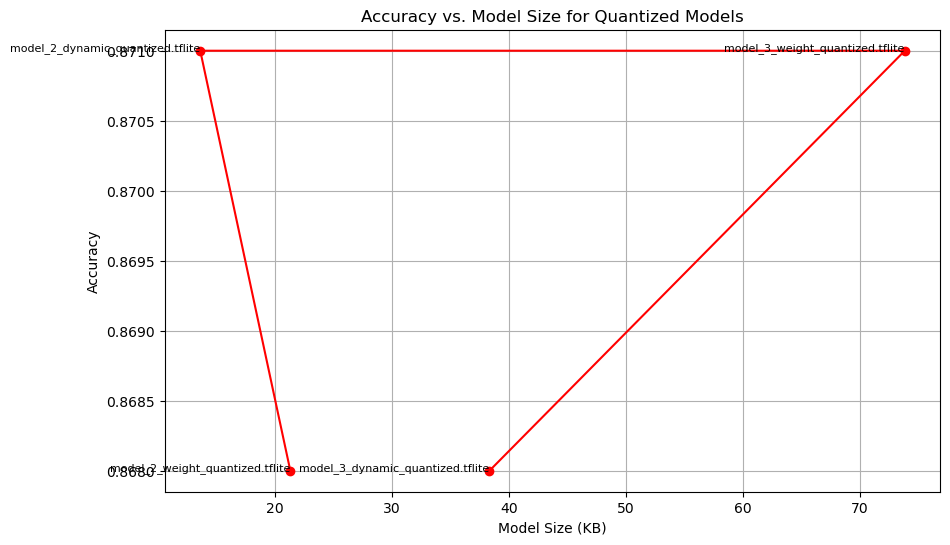

In [27]:
# List of quantized model filenames
quantized_model_filenames = []
for i in range(1, len(models) + 1):
    for strategy in ['weight', 'full', 'dynamic']:
        quantized_model_filenames.append(f'model_{i}_{strategy}_quantized.tflite')
    quantized_model_filenames.append(f'model_{i}_int16x8_quantized.tflite')

# Print sizes of quantized models and store the sizes
print("\nQuantized Model Sizes:")
quantized_model_sizes = print_quantized_model_sizes(quantized_model_filenames)

# Evaluate each quantized model and collect accuracies
quantized_accuracies = []

for model_filename, model_size in quantized_model_sizes:
    print(f'Evaluating {model_filename}')
    accuracy = evaluate_quantized_model(model_filename)
    quantized_accuracies.append((model_filename, model_size, accuracy))

filtered_accuracies = [tup for tup in quantized_accuracies if tup[2] > 0.8]

# Plot accuracy vs. model size for quantized models
model_names, model_sizes, accuracies = zip(*filtered_accuracies)

plt.figure(figsize=(10, 6))
plt.plot(model_sizes, accuracies, marker='o', linestyle='-', color='r')

for i, model_name in enumerate(model_names):
    plt.text(model_sizes[i], accuracies[i], model_name, fontsize=8, ha='right')

plt.xlabel('Model Size (KB)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Model Size for Quantized Models')
plt.grid(True)
plt.show()